In [1]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.2 MB/s eta 0:00:00


In [2]:
!python --version

Python 3.11.11


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve, LearningCurveDisplay, train_test_split, KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/final_dg_data.csv')

In [5]:
df['smiles'] = df['smiles'].apply(Chem.CanonSmiles)
df.drop_duplicates(subset=['smiles'], inplace=True, ignore_index=True)

In [6]:
class Fingerprint:

    # This class is is equivalent to a data class which contains information about morgan fingerprint

    fingerprints = []

    def __init__(self, mol, bit_vector, on_bits, bit_info, include=True):
        self.mol = mol # molecule from which the fingerprint is generated
        self.bit_vector = bit_vector # bit vector
        self.on_bits = on_bits # set of indices in bit vector having a value of 1
        self.bit_info = bit_info # fragments encoded in the bits having value of 1

        if include:
            Fingerprint.fingerprints.append(self) # Keeps a record of each fingerprint created


class MorganFingerprint:

    # This class contains the parameters for Morgan fingerprints and featurize funtion

    mols = []

    def __init__(self, nbits:int, radius:int, features:bool, chirality:bool, include:bool):
        self.nbits = nbits
        self.radius = radius
        self.features = features
        self.chirality = chirality
        self.include = include

    def featurize(self, mol):
        MorganFingerprint.mols.append(mol)
        bit_info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(
                mol,
                self.radius,
                nBits = self.nbits,
                useFeatures = self.features,
                useChirality = self.chirality,
                bitInfo = bit_info
            )

        return Fingerprint(mol=mol,
                           bit_vector=np.array(fp),
                           on_bits=sorted(set(fp.GetOnBits())),
                           bit_info=bit_info,
                           include=self.include
                          )

In [7]:
def smiles_transformer(smiles_data, fingerprint_large_radius, fingerprint_small_radius):
    smiles_list = smiles_data.values
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    X = []
    for mol in mols:
        fp_all_fragments = fingerprint_large_radius.featurize(mol).bit_vector.tolist()
        fp_smaller_fragments = fingerprint_small_radius.featurize(mol).bit_vector.tolist()

        smaller_fragment_indexes = []
        for i in range(len(fp_smaller_fragments)):
            if fp_smaller_fragments[i] == 1:
                smaller_fragment_indexes.append(i)
            i += 1

        for index in smaller_fragment_indexes:
            fp_all_fragments[index] = 0

        X.append(fp_all_fragments)

    return X

In [8]:
NBITS = 1024
RADIUS = 2

In [9]:
morgan_fingerprint = MorganFingerprint(
    nbits=NBITS,
    radius=RADIUS,
    features=True,
    chirality=True,
    include=True
)

smaller_fragments_morgan_fingerprint = MorganFingerprint(
    nbits=NBITS,
    radius=RADIUS-1,
    features=True,
    chirality=True,
    include=False
)

In [10]:
X = smiles_transformer(df["smiles"], morgan_fingerprint, smaller_fragments_morgan_fingerprint)
y = df["selectivity"].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 500, 1000]
}

In [13]:
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'max_iter': [100, 500, 1000],
                         'penalty': ['l2'], 'solver': ['liblinear']},
             scoring='f1_weighted')

In [14]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [15]:
model = grid_search.best_estimator_

Gap between training and validation scores at full dataset size: 0.0465


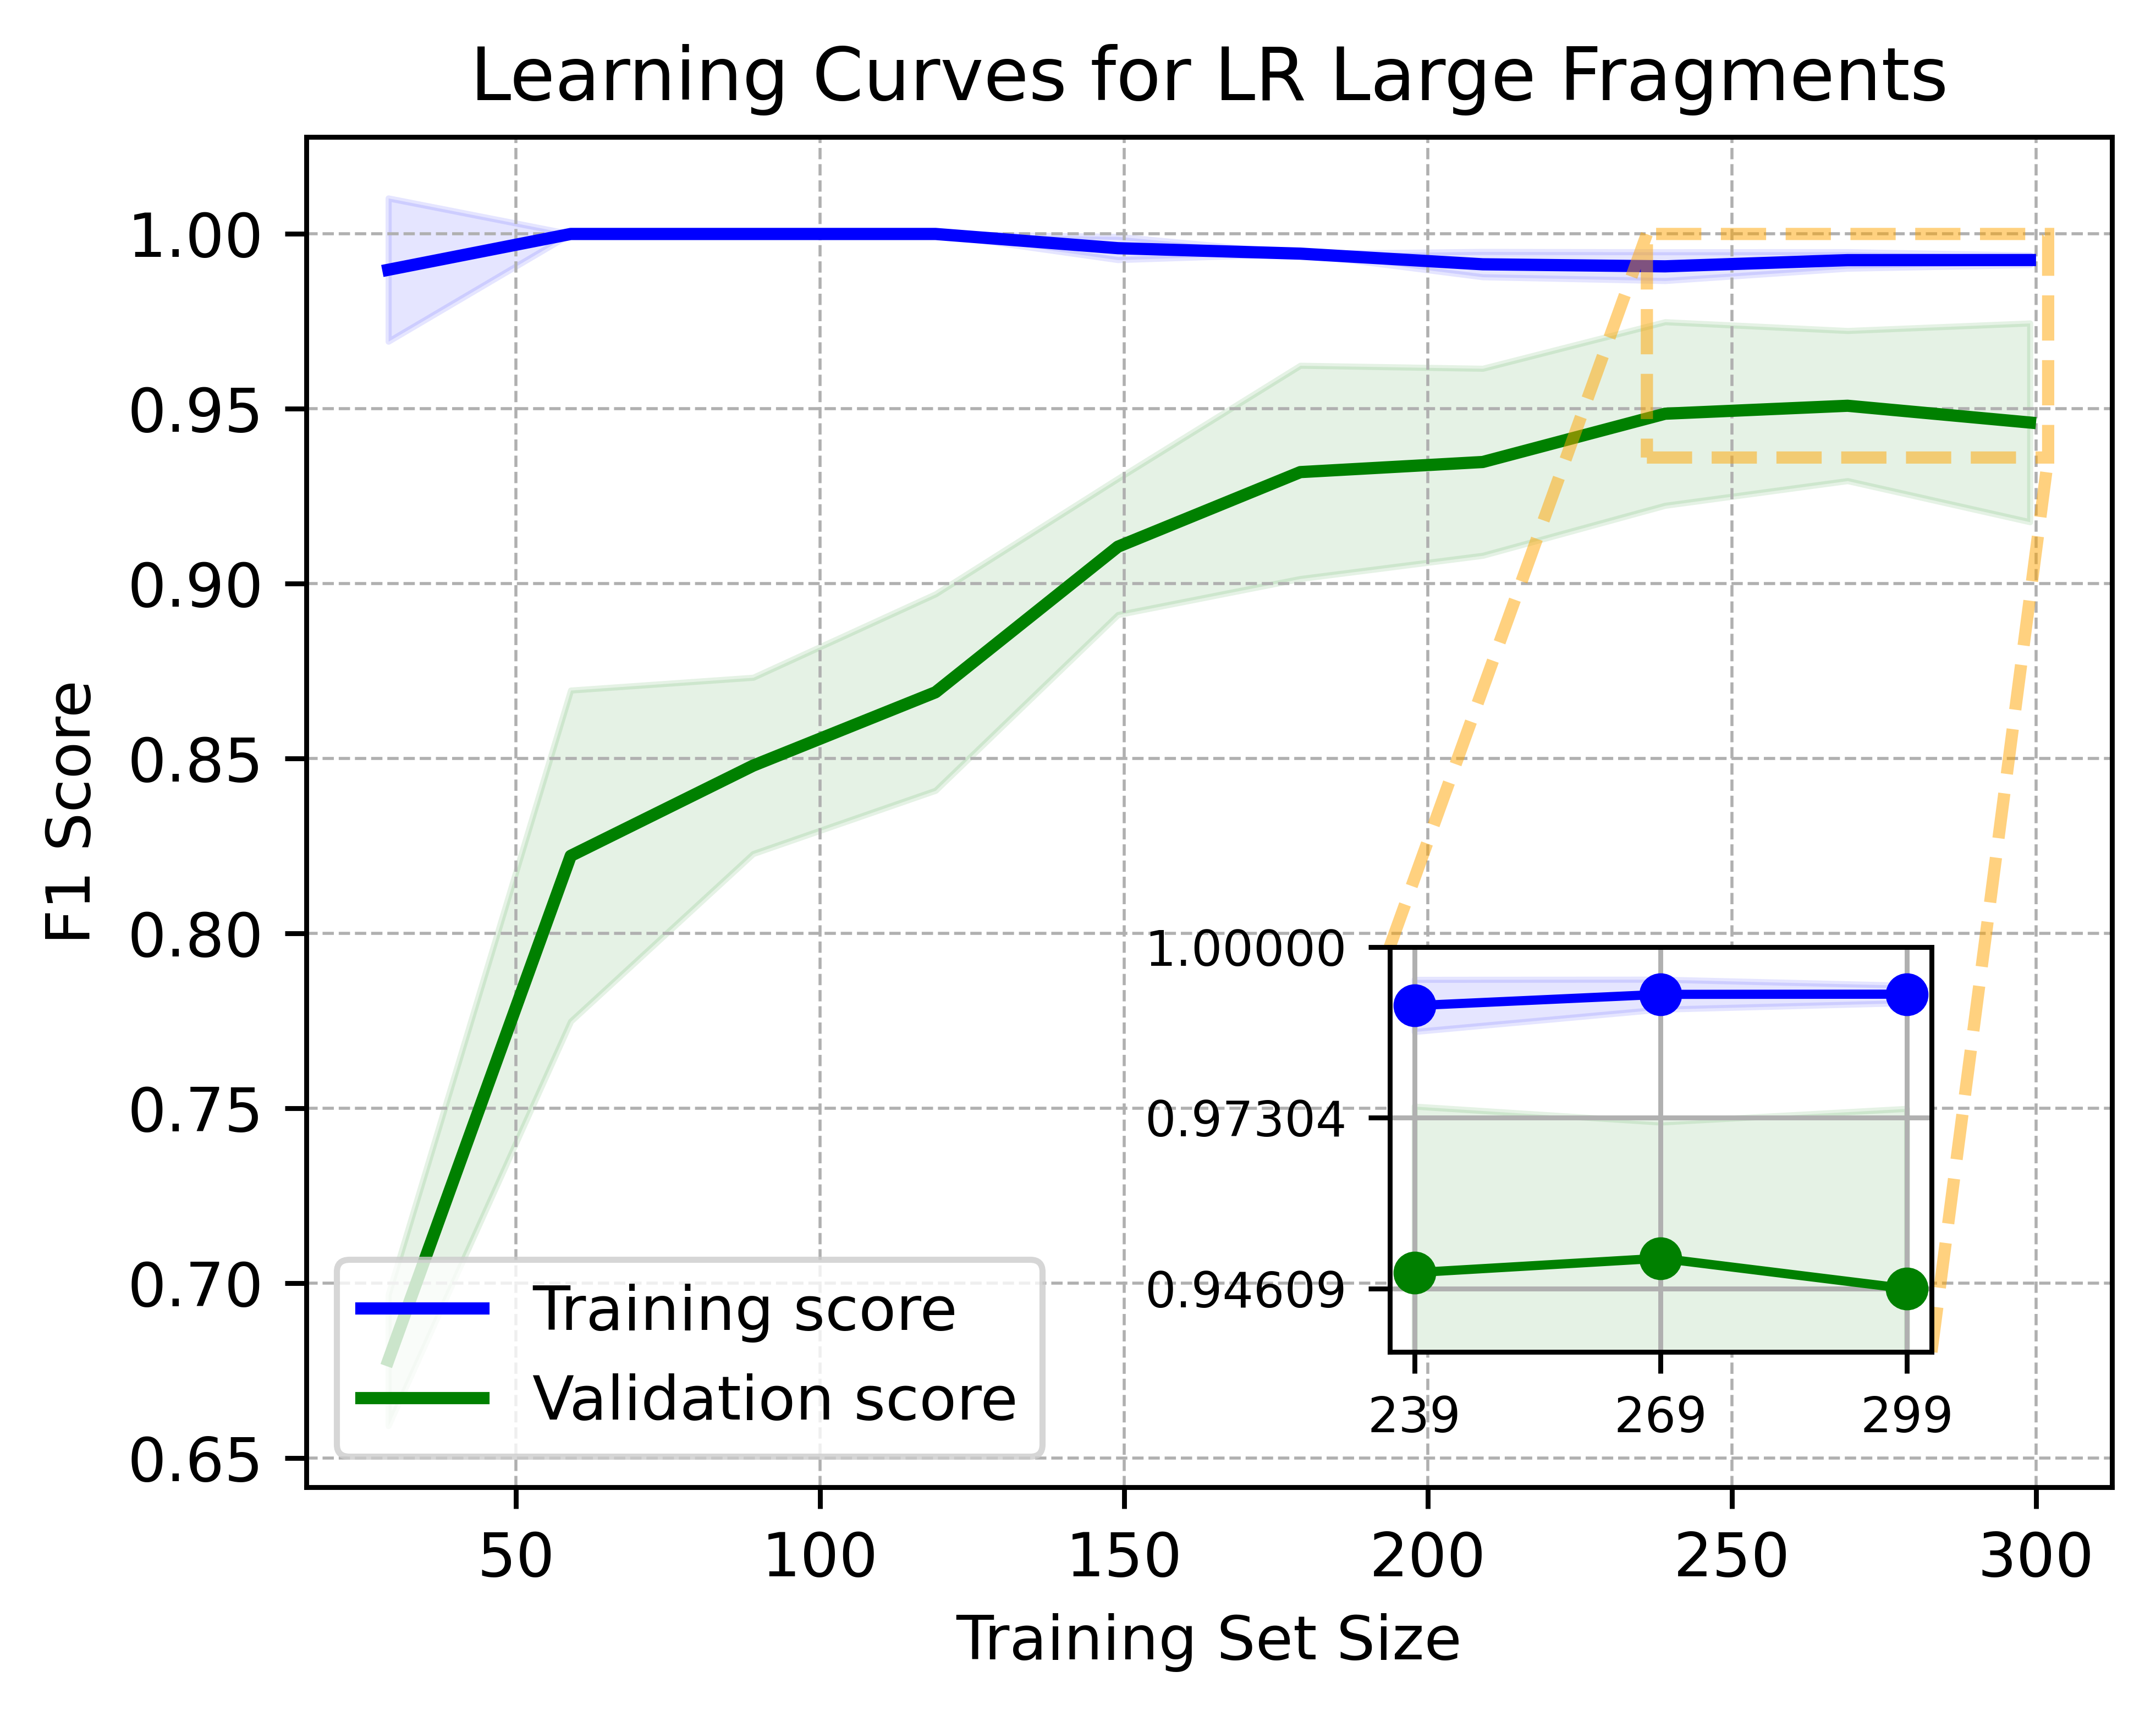

In [23]:
# 1. **Learning Curves**
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and std deviation for the learning curves
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the gap between training and validation scores at the largest training size
gap_at_full_data = train_mean[-1] - test_mean[-1]
print(f"Gap between training and validation scores at full dataset size: {gap_at_full_data:.4f}")

# Create the figure with high resolution
plt.figure(figsize=(5, 4), dpi=800)

# Plot the learning curves
plt.plot(train_sizes, train_mean, label="Training score", color="blue", linewidth=2)
plt.plot(train_sizes, test_mean, label="Validation score", color="green", linewidth=2)

# Fill between the standard deviations
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)

# Add zoomed-in inset plot for the last few points to observe convergence
ax = plt.gca()  # Get the current axes
zoomed_inset = ax.inset_axes([0.6, 0.1, 0.3, 0.3])  # Inset plot within main plot

# Plot the zoomed-in learning curve
zoomed_inset.plot(train_sizes[-3:], train_mean[-3:], 'o-', color="blue", label="Training score")
zoomed_inset.plot(train_sizes[-3:], test_mean[-3:], 'o-', color="green", label="Validation score")
zoomed_inset.fill_between(train_sizes[-3:], train_mean[-3:] - train_std[-3:], train_mean[-3:] + train_std[-3:], alpha=0.1, color="blue")
zoomed_inset.fill_between(train_sizes[-3:], test_mean[-3:] - test_std[-3:], test_mean[-3:] + test_std[-3:], alpha=0.1, color="green")

# Set labels and title for the zoomed-in inset
zoomed_inset.set_xticks(train_sizes[-3:])
zoomed_inset.set_yticks(np.linspace(min(train_mean[-3:].min(), test_mean[-3:].min()), 1, 3))  # Grid lines end at 1
zoomed_inset.set_ylim([min(train_mean[-3:].min(), test_mean[-3:].min()) - 0.01, 1])  # Y-axis ends at 1
zoomed_inset.tick_params(axis='both', which='major', labelsize=8,)
zoomed_inset.grid(True)

# Label the axes and the plot
plt.title("Learning Curves for LR Large Fragments")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend(loc="lower left")

# Customize the main plot grid for better visibility
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a zoom box to indicate the inset area
ax.indicate_inset_zoom(zoomed_inset, linestyle="--", edgecolor="orange", linewidth=2)

plt.tight_layout()
plt.savefig("learning_curve_LR_large_fragments.tiff", dpi=800, format='tiff', bbox_inches="tight")

# Show the plot
plt.show()

In [24]:
last_validation_score = test_mean[-1]
print("Last Validation Score (at maximum training set size):", last_validation_score)

Last Validation Score (at maximum training set size): 0.94608754961727


In [25]:
model.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [42]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        meta       0.94      1.00      0.97        16
        none       0.98      0.98      0.98        59
       ortho       1.00      0.86      0.92         7
        para       1.00      1.00      1.00        12

    accuracy                           0.98        94
   macro avg       0.98      0.96      0.97        94
weighted avg       0.98      0.98      0.98        94



In [27]:
model_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Overall F1 Score (weighted):", model_f1_score)

Overall F1 Score (weighted): 0.9784754252839359


In [28]:
mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)

Matthews Correlation Coefficient (MCC): 0.9618075617629472


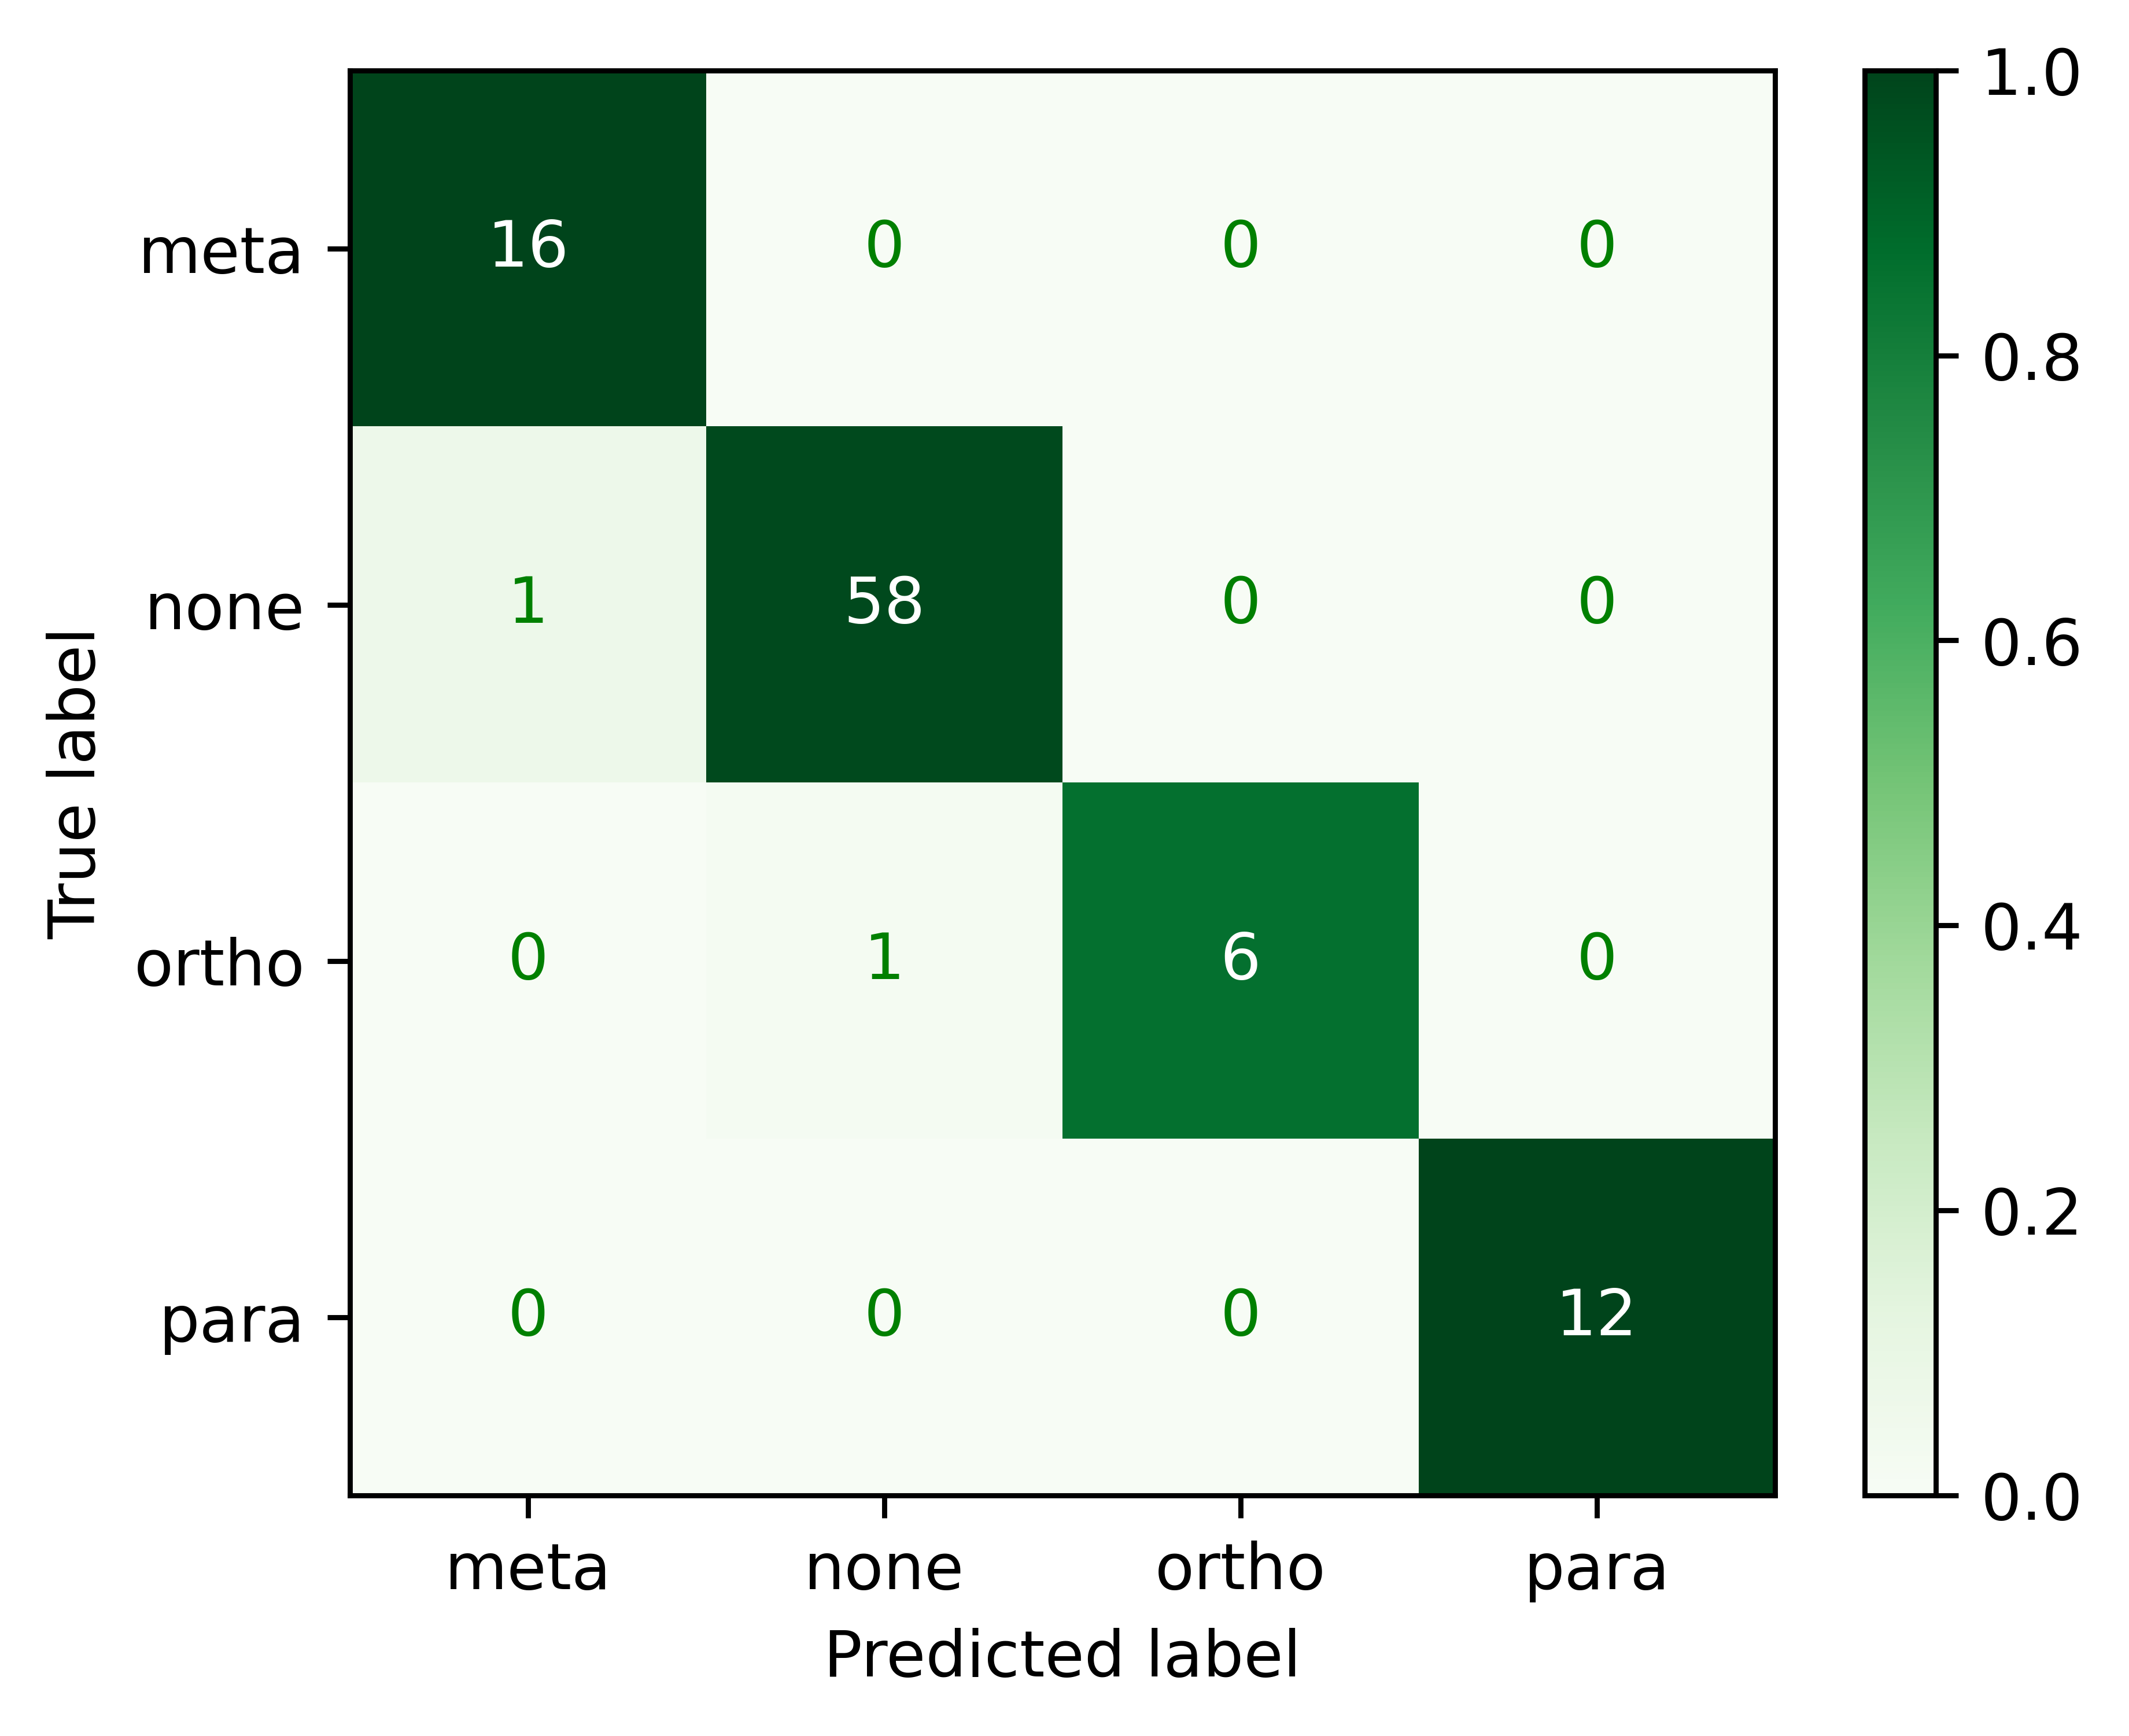

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

classes = model.classes_
accuracies = cm/cm.sum(1)
fig, ax = plt.subplots(figsize=(5,4), dpi=800)
cb = ax.imshow(accuracies, cmap='Greens')
plt.xticks(range(len(classes)), classes, rotation=0)
plt.yticks(range(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        color='green' if accuracies[i,j] < 0.5 else 'white'
        ax.annotate(f'{cm[j,i]}', (i,j),
                    color=color, va='center', ha='center')

# Add colorbar and make its numbers bold
cbar = plt.colorbar(cb, ax=ax)
cbar.ax.yaxis.set_tick_params(labelsize=10)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("confusion_matrix_LR_large_fragment.tif", dpi=800, bbox_inches="tight")
plt.show()

In [33]:
def enumerate_and_sort(coef_array):
    '''
    This function takes a 2d array of values and returns another 2d array of dictionary
    the final array has
    '''

    # Coeffecient array contains coeffecients assigned to each feature along columns for each class along rows
    # Shape : (number of classes, number of features)

    enumerated_list = []

    for class_coefs in coef_array:

        # class_coefs contains list of coeffecients assigned to corresponding features for a particular class.

        index_value_list = []
        index = 0

        for feature_coef in class_coefs:
            index_value = {'index': index, 'value': feature_coef}
            index_value_list.append(index_value)
            index += 1
        enumerated_list.append(index_value_list)

    for enumerated in enumerated_list:
        enumerated.sort(key=lambda index_value: abs(index_value['value']), reverse=True)

    return enumerated_list

In [34]:
def get_important_morgan_fragments(model, fingerprints:list, fragments_per_class):

    '''
    This function takes a scikit-learn machine learning model, a list, and
    an integer as arguments.

    model : scikit-learn model with coefs_ attribute
    fingerprints: a list of Fingeprint objects
    fragments_per_class: maximum number of important fragments whose information is to be extracted

    Returns an array of shape (number of classes, fragments_per_class)
    '''

    # `model.coef_` returns an array of shape (number of classes, number of features)
    # The cells of the array contains coeffecient of a feature for the corresponding class.
    coef_array = model.coef_

    # getting a list of dictionaries containing feature index and coeffecient value arranged according
    sorted_coefs = enumerate_and_sort(coef_array)
    bit_infos = []
    all_on_bits = []
    for fingerprint in fingerprints:
        bit_infos.append(fingerprint.bit_info)
        all_on_bits.append(fingerprint.on_bits)

    imp_coefs = []
    for coef_list in sorted_coefs:
        imp_coefs.append(coef_list[:fragments_per_class])

    fragments_array = []
    legends_array = []

    for bit_list in imp_coefs:
        fragments = []
        legends = []
        for index_value in bit_list:
            index = index_value.get('index')
            index_found = False
            for fingerprint in fingerprints:
                if index in fingerprint.on_bits:
                    index_found = True
                    mol = fingerprint.mol
                    bit_info = fingerprint.bit_info
                    legends.append(f"bit: {index_value.get('index')} | value: {round(index_value.get('value'), 4)}")
                    fragments.append((mol, index, bit_info))
                    break
            if not index_found:
                print("Warning Bit not found")

        fragments_array.append(fragments)
        legends_array.append(legends)
    return fragments_array, legends_array

In [35]:
fragments_array, legends_array = get_important_morgan_fragments(model, Fingerprint.fingerprints, 16)

para


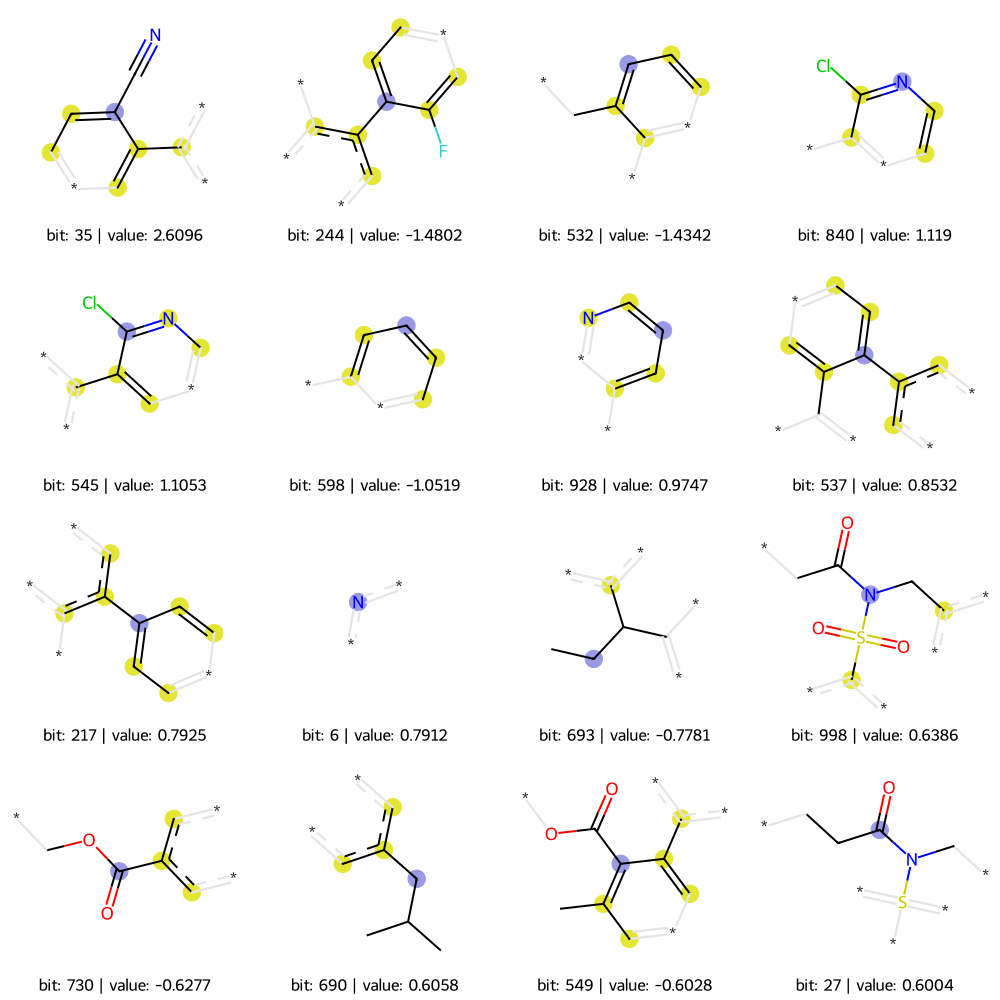

In [40]:
print(model.classes_[3])
Draw.DrawMorganBits(fragments_array[3][:100],
                    legends=legends_array[3][:100],
                    molsPerRow=4,
                    useSVG=True,
                    subImgSize=(250, 250)
                   )

In [41]:
for i in range(len(model.classes_)):
    with open(f'./{model.classes_[i]}_classifiers_all_fragment_logistic_regression.svg','wb+') as outfile:
         outfile.write(Draw.DrawMorganBits(fragments_array[i][:16],
                                           legends=legends_array[i][:16],
                                           molsPerRow=4,
                                           useSVG=True,
                                           subImgSize=(250, 250)).data.encode('utf-8'))